In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [27]:
from sklearn.model_selection import train_test_split

In [9]:
def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f"ML-datasets/{filename}.csv", index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes


def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'breast_cancer': {'class_column': 'Class', 'index_col': 'Sample code number'},
              'diabetes': {'class_column': 'Class', 'index_col': None}}
    dataset, classes = load_dataset(dataset_name, **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [10]:
X, y, classes = prepare_dataset('diabetes')

In [12]:
y.value_counts()

class
0    500
1    268
Name: count, dtype: int64

In [14]:
normalizer = Normalizer()
standarizer = StandardScaler()
preprocessor = standarizer

--------------------

## Testy na zbiorach danych

In [15]:
def preprocessor_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [21]:
def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

In [22]:
def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy: {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall: {metrics[2]}')
    print(f'  f1 score: {metrics[3]}')
    print(f'  Mislabeled: {metrics[4]}')
    print('\n')

In [33]:
def plot_confusion_matrix(confusion_matrix, classes, title=None, title_appendix='', cmap=plt.cm.Blues):
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'(Condusion matrix {title_appendix}'

    fig, ax = plt.subplots()
    img = ax.imshow(confusion_matrix, cmap=cmap)
    ax.figure.colorbar(img, ax=ax)
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                   ha = 'center', va='center',
                   color='white' if cell > thresh else 'black')

    fig.tight_layout()
    return ax

In [25]:
def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[np.newaxis].T

In [26]:
X, y, classes = prepare_dataset('wine')
X = preprocessor_data(X, standarizer)
X.describe()

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
print(y.value_counts)
print(y_train.value_counts)
print(y_test.value_counts)

<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
173    1
174    1
175    1
176    1
177    1
Name: class, Length: 178, dtype: int8>
<bound method IndexOpsMixin.value_counts of 87     2
26     0
2      0
36     0
102    2
      ..
148    1
59     2
64     2
34     0
103    2
Name: class, Length: 142, dtype: int8>
<bound method IndexOpsMixin.value_counts of 10     0
129    2
28     0
131    1
143    1
51     0
7      0
95     2
81     2
86     2
82     2
65     2
42     0
63     2
14     0
137    1
93     2
20     0
133    1
38     0
136    1
146    1
22     0
18     0
164    1
165    1
58     0
70     2
169    1
106    2
48     0
92     2
173    1
99     2
91     2
113    2
Name: class, dtype: int8>


In [32]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy: 0.9166666666666666
  Precision: 0.923076923076923
  Recall: 0.9246031746031745
  f1 score: 0.9229629629629629
  Mislabeled: 3




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

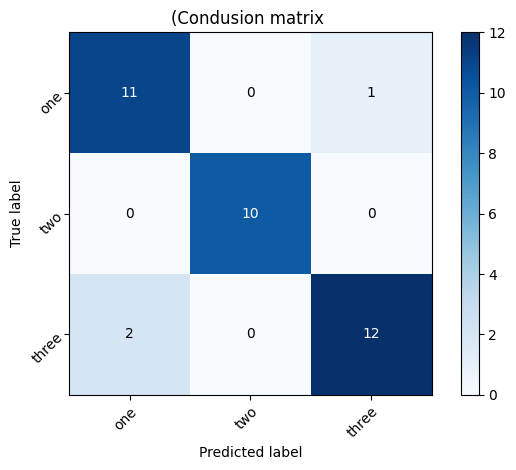

In [34]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

In [36]:
bclf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
bclf.fit(X_train, y_train)
y_b = bclf.predict(X_test)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Results for Bagging Ensamble
----
  Accuracy: 1.0
  Precision: 1.0
  Recall: 1.0
  f1 score: 1.0
  Mislabeled: 0




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

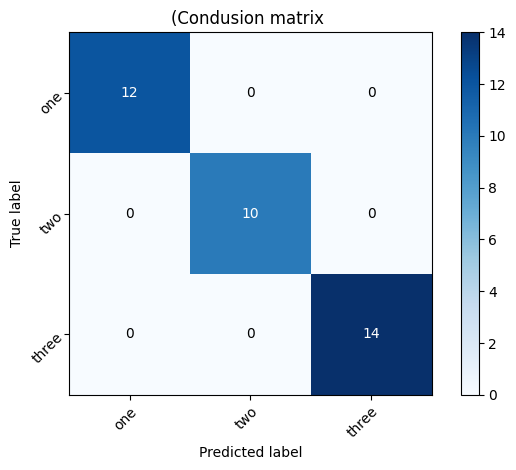

In [37]:
print_results(calculate_metrics(y_test.values, y_b), 'Bagging Ensamble')
cm = confusion_matrix(y_test, y_b)
plot_confusion_matrix(cm, classes)